# Practical Application: Comparing Classifiers

**Overview**: In this practical application, our goal is to compare the performance of the following classifiers: namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Dataset

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### 1 Understanding the Data

To gain a better understanding of the data, read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper. 

As explained in the accompanying paper: The dataset collected is related to **17 campaigns** that occurred **between May 2008 and November 2010**, corresponding to a total of **79354 contacts**. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were **6499 successes (8% success rate)**.

### 2: Read in the Data

We use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, roc_curve, RocCurveDisplay, confusion_matrix
import time
import warnings

In [131]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [132]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 3: Understanding the Features


We examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [134]:
#let's look at categorical values and how many of each:
print(f"Unique Values for categorical columns:")
for col in df.select_dtypes(include='object'):
  print(f"  {df[col].nunique()} unique values - {col}: {df[col].unique()}\n")

Unique Values for categorical columns:
  12 unique values - job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

  4 unique values - marital: ['married' 'single' 'divorced' 'unknown']

  8 unique values - education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

  3 unique values - default: ['no' 'unknown' 'yes']

  3 unique values - housing: ['no' 'yes' 'unknown']

  3 unique values - loan: ['no' 'yes' 'unknown']

  2 unique values - contact: ['telephone' 'cellular']

  10 unique values - month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

  5 unique values - day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

  3 unique values - poutcome: ['nonexistent' 'failure' 'success']

  2 unique values - y: ['no' 'yes']



In [48]:
# do we have duplicates?
duplicates = len(df)-len(df.drop_duplicates())
print(f" dropped {duplicates} duplicates")

 dropped 12 duplicates


In [49]:
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

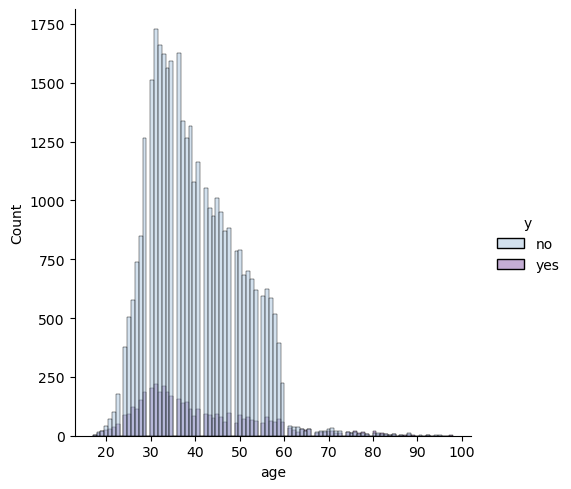

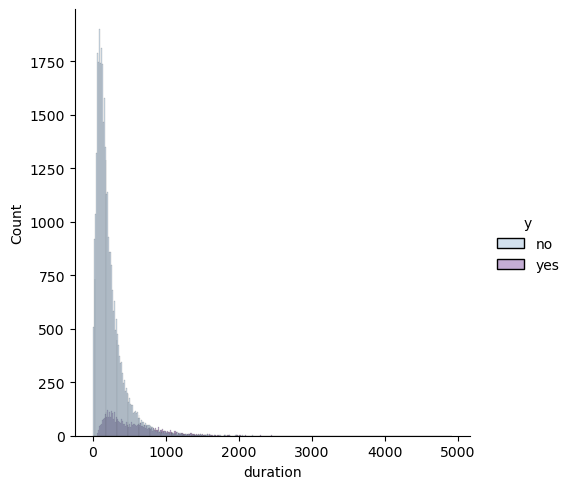

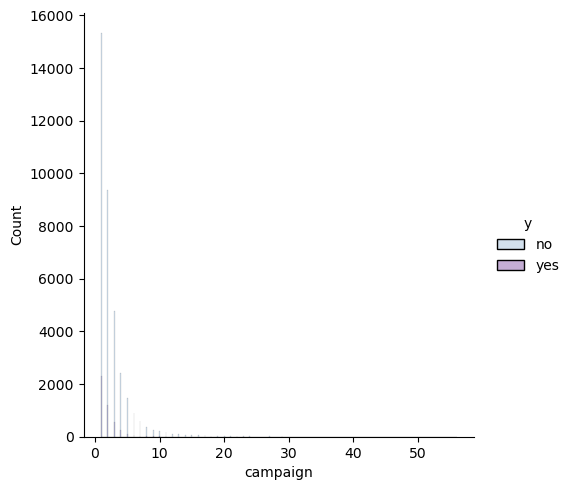

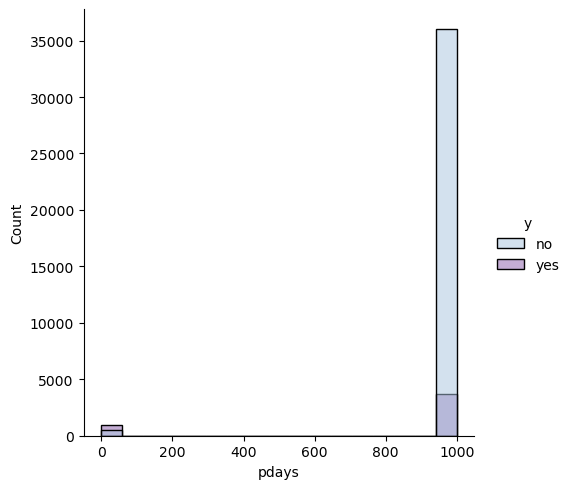

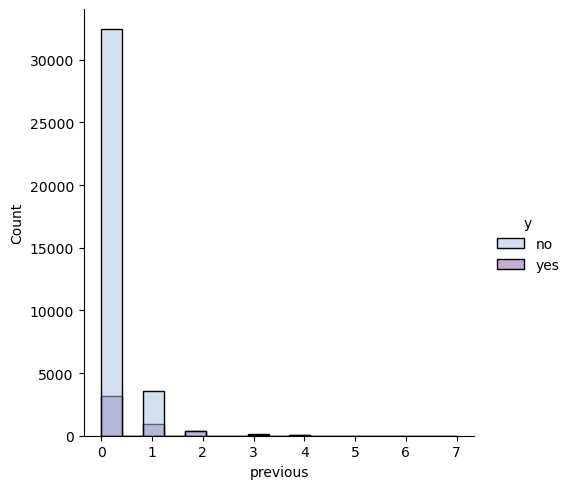

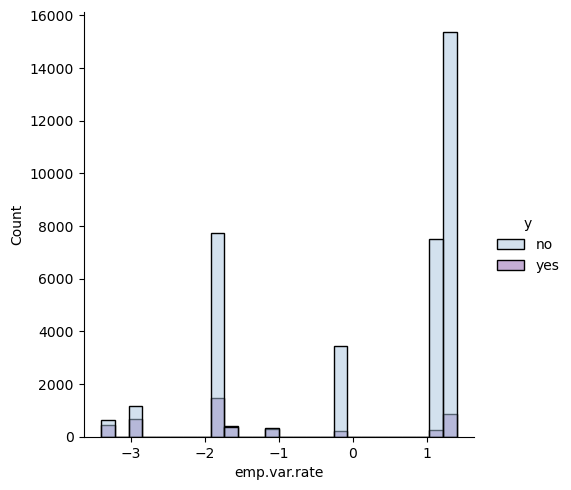

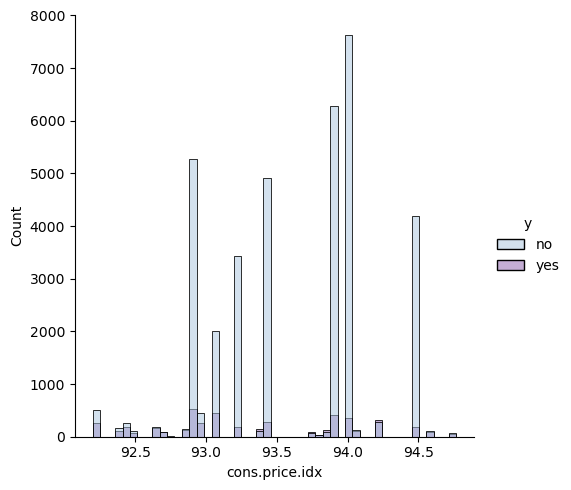

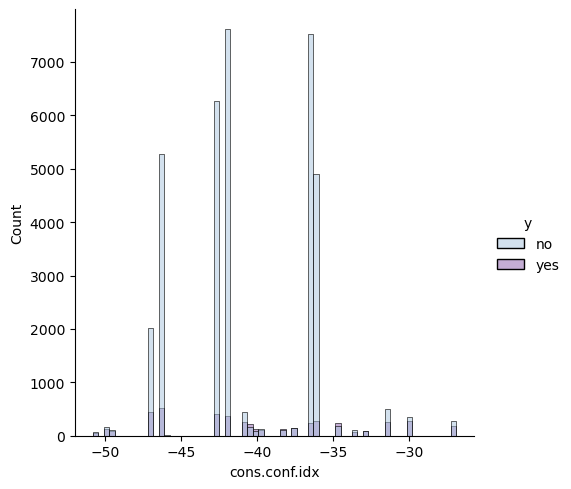

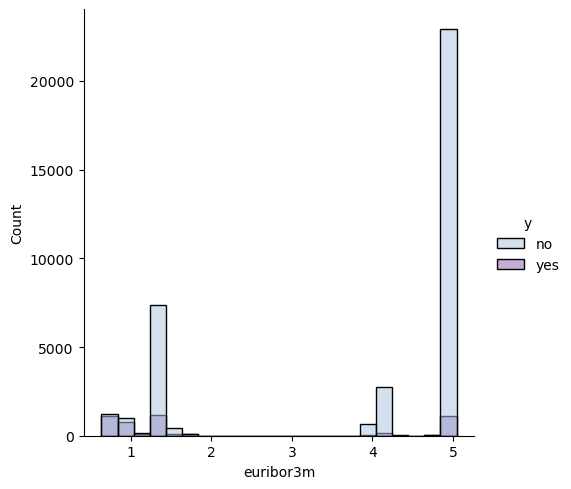

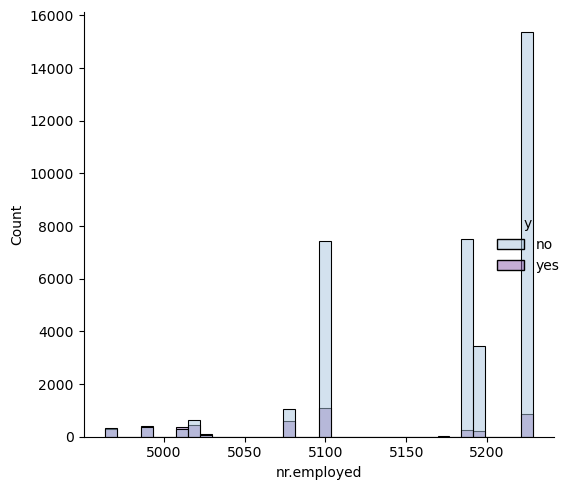

In [136]:
#let's plot the distribution of numerical features for eda
num_features = df[[ 'age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
#due to the version of seaborn we get layout tight warnings, in the final version here we supress to make pretty:
warnings.filterwarnings('ignore')
for i , subplots in zip (num_features, ax.flatten()):  
  sns.displot(x=num_features[i], hue = df['y'], palette = 'BuPu')
plt.tight_layout()

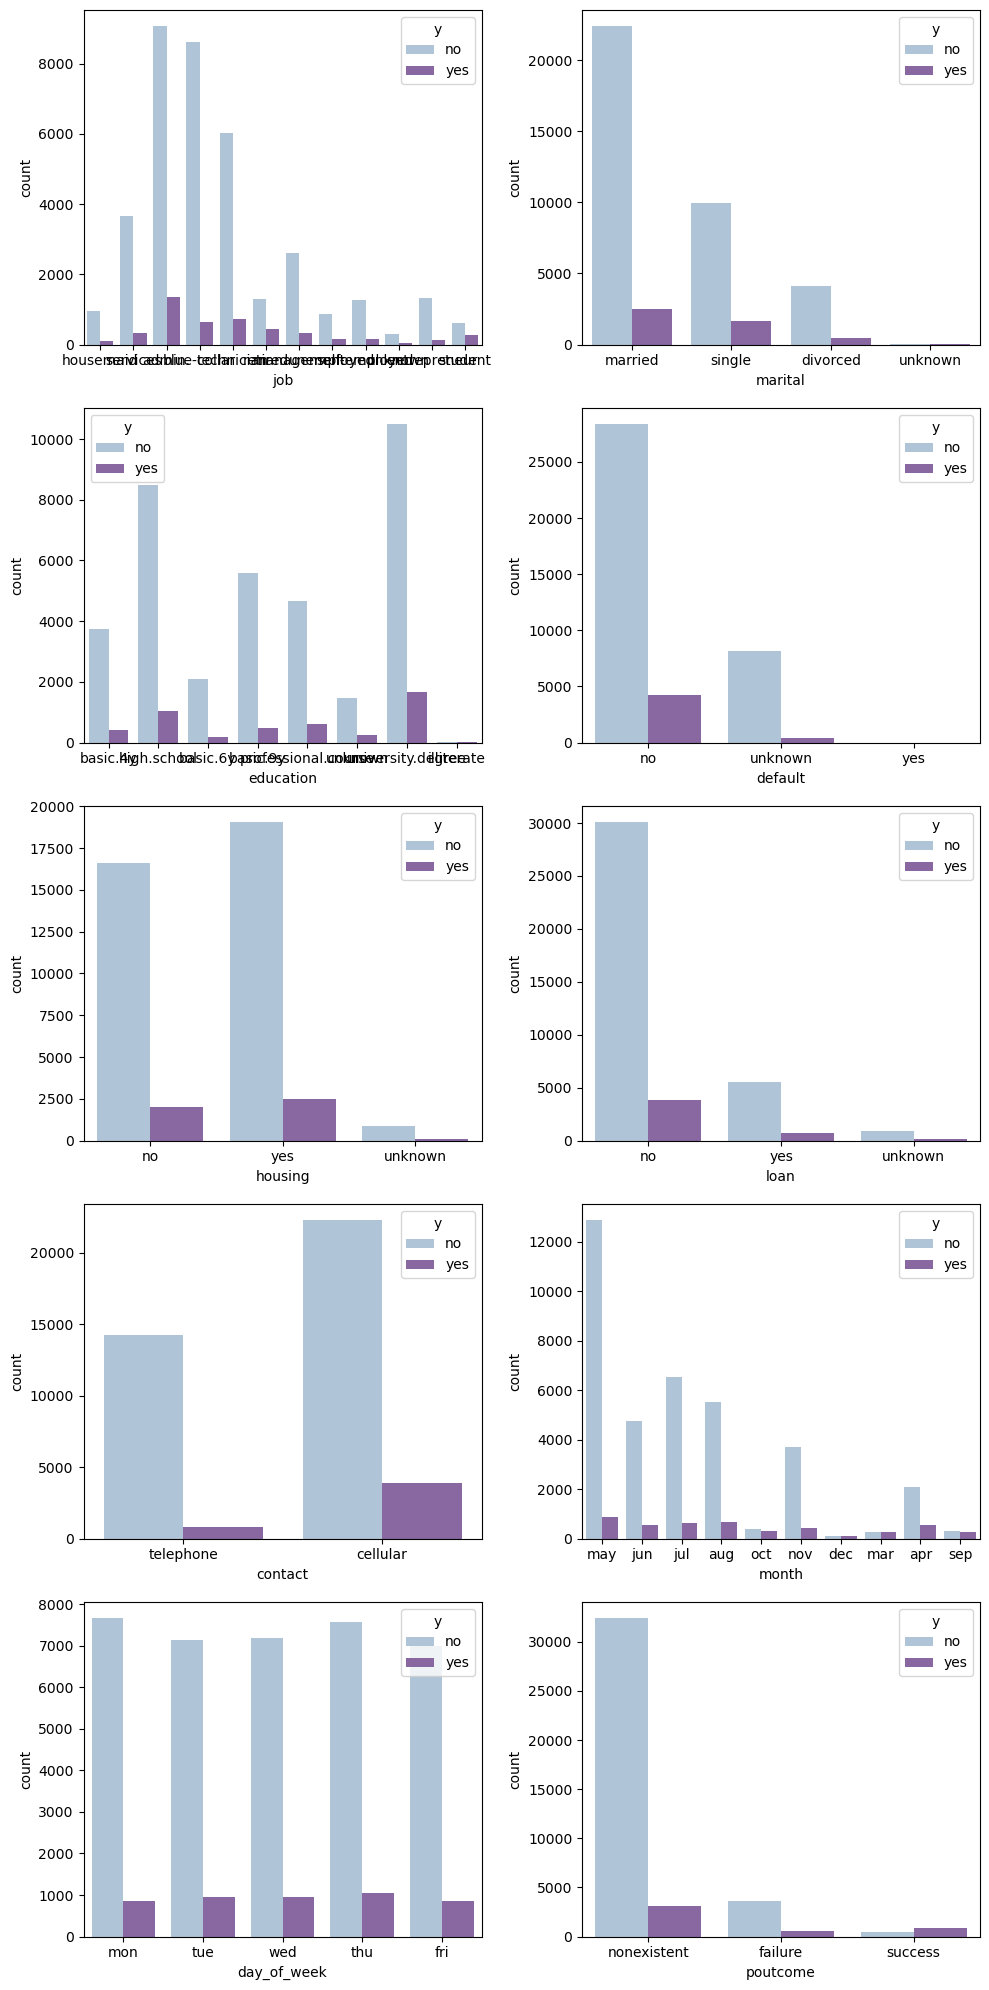

In [44]:
#let's look at how many values for each categorical in each column

cat_features = df[[ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]

fig, ax = plt.subplots(5,2,figsize = (10,20))     # set up 5 x 2 frame count plot with figsize 10 x 10
for i , subplots in zip (cat_features, ax.flatten()):  
  sns.countplot(x=cat_features[i], hue = df['y'], ax = subplots, palette = 'BuPu')
plt.tight_layout()

### 4: Understanding the Task

**Business Objective** of the task:

**Our goal is to increase marketing effeciency of campaigns for long term deposit subscriptions by reducing the amount of contacts that the team needs to contact that are not likely to close.** 

### 5: Engineering Features

Now that we understand our business objective, we can build our baseline and other models.  Before we do this, we must encode and scale the data.  As we have the intention of using pipelines we can do this with a column transformer as follows:

In [50]:
#data tranformation: convert objects to numeric values using ohe, scale the rest
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']),
                                     remainder = StandardScaler())

### 6: Train/Test Split

We now split our data into a train and test set using stratify on our target to respect the balance of our target (8% positive).

In [143]:
X = df.drop(columns = 'y')
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = df.y)

### 7: A Baseline Model

Before we build our first full model, we want to establish a baseline.  Here we use a dummyclassifier with stratified data (to respect the original unbalanced data):

In [144]:
#Function for evaluation metrics
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

baseline_results_dict = {'accuracy': [accuracy_score(y_test, y_pred)],
                'recall': [recall_score(y_test, y_pred, pos_label='yes')],
                'precision': [precision_score(y_test, y_pred, pos_label='yes')],
                'f1_score': [f1_score(y_test, y_pred, pos_label='yes')]}
baseline_results = pd.DataFrame(baseline_results_dict)
baseline_results

,accuracy,recall,precision,f1_score
0,0.797805,0.127586,0.121511,0.124474


### 8: Our First Model

Here we create an array to put our model results in and then create an extractor to select what features to use in our pipeline with logistic regression.  Then finally we use gridsearch cross validation to select our best model parameters based on accuracy.   

In [145]:
results = {
    'Model' : [],
    'Best Params' : [],
    'Score' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'Train Time' : [],
    'Inference Time' : [],
    'Optimization Time' : []
}

In [146]:
# 1 Logistic Regression with a gridsearch for best parameters:
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
lr_pipe = Pipeline([
    ('transform', transformer), 
    ('selector', extractor),
    ('logistic', LogisticRegression())
])
t0 = time.time()
lr_pipe.fit(X_train, y_train)
train_time = time.time() - t0
t1 = time.time()
y_pred = lr_pipe.predict(X_test)
inference_time = time.time() - t1
#A grid search CV to find optimal hyperparam values
t3 = time.time()
lr_grid = GridSearchCV(lr_pipe, param_grid={'logistic__penalty': ["l2"], 'logistic__C': [0.1, 1, 10, 100], 'logistic__max_iter': [1000], 'logistic__solver' : ['sag']})
lr_grid.fit(X_train, y_train)
optimization_time = time.time() - t3

model = 'Logistic Regression'
# Get the best estimator from the GridSearchCV
best_pipe = lr_grid.best_estimator_
best_params = lr_grid.best_params_
test_score = lr_grid.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

results['Model'].append(model)
results['Best Params'].append(best_params)
results['Score'].append(test_score)
results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1-Score'].append(f1)
results['Train Time'].append(train_time)
results['Inference Time'].append(inference_time)
results['Optimization Time'].append(optimization_time)

print(results)

{'Model': ['Logistic Regression'], 'Best Params': [{'logistic__C': 1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}], 'Score': [0.9151209090026221], 'Accuracy': [0.9151209090026221], 'Precision': [0.7002801120448179], 'Recall': [0.43103448275862066], 'F1-Score': [0.5336179295624331], 'Train Time': [4.555016994476318], 'Inference Time': [0.0186312198638916], 'Optimization Time': [82.90155601501465]}


### 9: Scoring our Logistic Regression Model & Feature Coefficients

Above we can see the output of our optimized model with an accuracy of about ~ 0.915.  For our case it would be also usefull to gain an understanding of the features importance for the outcome beyond just predicting.  Below we extract the coefficients from our model and see housing_no has the biggest impact on positive outcome:

In [147]:
#let's extract the coefficients to see what influences the decisions most
best_pipe = lr_grid.best_estimator_
# Extract the feature names
feature_names = best_pipe.named_steps['transform'].get_feature_names_out()

# Extract the coefficients
coefficients = best_pipe.named_steps['logistic'].coef_[0]

# Print the feature names and coefficients in a nice dataframe:
coeffs = {
    'Name' : [],
    'Coeff' : []
}

for name, coef in zip(feature_names, coefficients):
    coeffs['Name'].append(name)
    coeffs['Coeff'].append(coef)

coeffs = pd.DataFrame(coeffs)
#clean up Coeff names from transformer
coeffs = coeffs.replace('onehotencoder__', '', regex=True)
coeffs.sort_values(by='Coeff', ascending=False)

,Name,Coeff
27,housing_no,1.742008
38,month_jun,1.206943
43,month_sep,1.092898
45,day_of_week_mon,0.703419
24,default_no,0.653880
14,marital_single,0.447838
5,job_retired,0.342057
8,job_student,0.174056
34,month_apr,0.143793
31,loan_unknown,0.139416


### 10: Other Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models using gridsearchCV to find the optimal parameters:


In [148]:
#2 KNN pipeline with a gridsearch for best K parameter using Roc Area Under Curve:
knn_pipe = Pipeline([
    ('transform', transformer), 
    ('knn', KNeighborsClassifier())
])
t0 = time.time()
knn_pipe.fit(X_train, y_train)
train_time = time.time() - t0
t1= time.time()
y_pred = knn_pipe.predict(X_test)
inference_time = time.time() - t1
#let's use a grid search CV to find optimal K value
t3 = time.time()
roc_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 63, 2)}, scoring = 'roc_auc')
roc_grid.fit(X_train, y_train)
optimization_time = time.time() - t3

model = 'K Nearest Neighbors'
# Get the best estimator from the GridSearchCV
best_pipe = roc_grid.best_estimator_
best_params = roc_grid.best_params_
test_score = roc_grid.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

results['Model'].append(model)
results['Best Params'].append(best_params)
results['Score'].append(test_score)
results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1-Score'].append(f1)
results['Train Time'].append(train_time)
results['Inference Time'].append(inference_time)
results['Optimization Time'].append(optimization_time)

print(results)

{'Model': ['Logistic Regression', 'K Nearest Neighbors'], 'Best Params': [{'logistic__C': 1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}, {'knn__n_neighbors': 61}], 'Score': [0.9151209090026221, 0.9374066414313912], 'Accuracy': [0.9151209090026221, 0.904923764203166], 'Precision': [0.7002801120448179, 0.6152866242038216], 'Recall': [0.43103448275862066, 0.4163793103448276], 'F1-Score': [0.5336179295624331, 0.49665809768637537], 'Train Time': [4.555016994476318, 0.09351396560668945], 'Inference Time': [0.0186312198638916, 0.24109792709350586], 'Optimization Time': [82.90155601501465, 41.656288146972656]}


In [149]:
#3 decision tree
dtc_pipe = Pipeline([
    ('transform', transformer), 
    ('dtc', DecisionTreeClassifier())
])
t0 = time.time()
dtc_pipe.fit(X_train, y_train)
train_time = time.time() - t0
t1= time.time()
y_pred = dtc_pipe.predict(X_test)
inference_time = time.time() - t1
#let's use a grid search CV to find optimal K value
t3 = time.time()
params = {'dtc__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
         'dtc__min_samples_split': [2,3,4,5,6],
          'dtc__criterion': ["entropy","gini"],
          'dtc__min_samples_leaf': [1,2,3,4,5]
         }
dtc_grid = GridSearchCV(estimator = dtc_pipe, param_grid = params, scoring = 'accuracy')
dtc_grid.fit(X_train, y_train)
optimization_time = time.time() - t3

model = 'Decision Tree Classifier'
# Get the best estimator from the GridSearchCV
best_pipe = dtc_grid.best_estimator_
best_params = dtc_grid.best_params_
test_score = dtc_grid.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

results['Model'].append(model)
results['Best Params'].append(best_params)
results['Score'].append(test_score)
results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1-Score'].append(f1)
results['Train Time'].append(train_time)
results['Inference Time'].append(inference_time)
results['Optimization Time'].append(optimization_time)

print(results)


{'Model': ['Logistic Regression', 'K Nearest Neighbors', 'Decision Tree Classifier'], 'Best Params': [{'logistic__C': 1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}, {'knn__n_neighbors': 61}, {'dtc__criterion': 'gini', 'dtc__max_depth': 5, 'dtc__min_samples_leaf': 4, 'dtc__min_samples_split': 2}], 'Score': [0.9151209090026221, 0.9374066414313912, 0.9171603379625134], 'Accuracy': [0.9151209090026221, 0.904923764203166, 0.8857919782460911], 'Precision': [0.7002801120448179, 0.6152866242038216, 0.4934426229508197], 'Recall': [0.43103448275862066, 0.4163793103448276, 0.5189655172413793], 'F1-Score': [0.5336179295624331, 0.49665809768637537, 0.5058823529411764], 'Train Time': [4.555016994476318, 0.09351396560668945, 0.23937368392944336], 'Inference Time': [0.0186312198638916, 0.24109792709350586, 0.017594099044799805], 'Optimization Time': [82.90155601501465, 41.656288146972656, 460.48103189468384]}


In [129]:
#4 SVM with a gridsearch NOTE: this takes almost 2hrs to run! 
svc_pipe = Pipeline([
    ('transform', transformer), 
    ('svc', SVC())
])
t0 = time.time()
svc_pipe.fit(X_train, y_train)
train_time = time.time() - t0

t2 = time.time()
y_pred = knn_pipe.predict(X_test)
inference_time = time.time() - t1
#let's use a grid search CV to find optimal K value
t3 = time.time()
svc_grid = GridSearchCV(svc_pipe, param_grid={'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'svc__gamma': [0.1, 1.0, 10.0, 100.0]}, scoring = 'accuracy')
svc_grid.fit(X_train, y_train)
optimization_time = time.time() - t3

model = 'SVM (Support Vector Machine)'
# Get the best estimator from the GridSearchCV
best_pipe = svc_grid.best_estimator_
best_params = svc_grid.best_params_
test_score = svc_grid.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

results['Model'].append(model)
results['Best Params'].append(best_params)
results['Score'].append(test_score)
results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1-Score'].append(f1)
results['Train Time'].append(train_time)
results['Inference Time'].append(inference_time)
results['Optimization Time'].append(optimization_time)

print(results)

{'Model': ['Logistic Regression', 'K Nearest Neighbors', 'Decision Tree Classifier', 'SVM (Support Vector Machine)'], 'Best Params': ['l2', 61, {'dtc__criterion': 'gini', 'dtc__max_depth': 5, 'dtc__min_samples_leaf': 4, 'dtc__min_samples_split': 2}, {'svc__gamma': 0.1, 'svc__kernel': 'rbf'}], 'Score': [0.9151209090026221, 0.9374066414313912, 0.9171603379625134, 0.9124987860541905], 'Accuracy': [0.9151209090026221, 0.904923764203166, 0.8875400602117122, 0.904923764203166], 'Precision': [0.7002801120448179, 0.6152866242038216, 0.5008347245409015, 0.6152866242038216], 'Recall': [0.43103448275862066, 0.4163793103448276, 0.5172413793103449, 0.4163793103448276], 'F1-Score': [0.5336179295624331, 0.49665809768637537, 0.5089058524173028, 0.49665809768637537], 'Train Time': [4.345444917678833, 0.0891273021697998, 0.22440695762634277, 8.577182054519653], 'Inference Time': [0.02029895782470703, 0.236558198928833, 0.017714977264404297, 821.5061230659485], 'Optimization Time': [82.70623779296875, 41

In [150]:
results = pd.DataFrame(results)
results

,Model,Best Params,Score,Accuracy,Precision,Recall,F1-Score,Train Time,Inference Time,Optimization Time
0,Logistic Regression,"{'logistic__C': 1, 'logistic__max_iter': 1000,...",0.915121,0.915121,0.700280,0.431034,0.533618,4.345445,0.020299,82.706238
1,K Nearest Neighbors,{'knn__n_neighbors': 61},0.937407,0.904924,0.615287,0.416379,0.496658,0.089127,0.236558,41.751909
2,Decision Tree Classifier,"{'dtc__criterion': 'gini', 'dtc__max_depth': 5...",0.917160,0.887540,0.500835,0.517241,0.508906,0.224407,0.017715,463.483905
3,SVM (Support Vector Machine),"{'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.912499,0.904924,0.615287,0.416379,0.496658,8.577182,821.506123,6650.176047


### 11: Improving the Model

We have already optimized our models with hyper parameter selection.  Additionally we could perform PCA on some of the slower models to see if we can reduce calculation time.  As stated below we can also tweak our decision threshold to better meet our business requirements.  

## Conclusion
For our case there is no catastrophic outcome if we wrongly predict a small amount of false positives (aka we predict a person will open a saving account but they don't). **A low precision and high recall model is recomended or in other words we can have an optimistic classifier.** On the other hand if we have limited sales personel and or a very costly sales follow up process we would want the inverse and have high precision and low recall. In our case we are using this data to trigger sales call activities; in this case the better tradeoff is to capture all potential customers reducing the amount of False negatives, and maybe have a few more False positives. **Thus we can further optimize our model by selecting a threshold on the lower end say 0.4 to acheive the above**. 